In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import torch
import torchvision 
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

#### Draw
from torchviz import make_dot
from torchsummary import summary

from IPython.display import display, HTML

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [4]:
torch.backends.cudnn.enabled = True
torch.manual_seed(8888);

## 准备数据集

In [5]:
n_samples = 25
data_root = '/data/datasets/torchvision/'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(data_root, train=True, transform=trans)
len(train_dataset)

60000

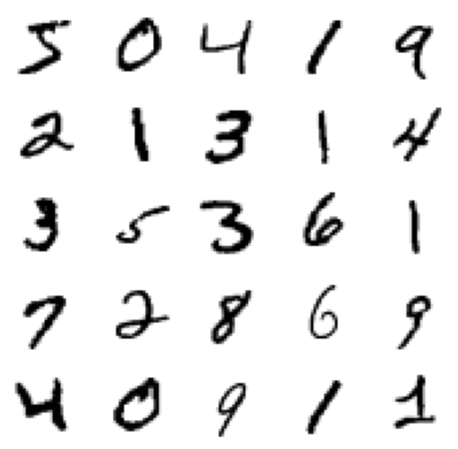

In [6]:
plt.figure(figsize=(8, 8))
for i in range(n_samples):
    img = train_dataset[i][0]
    img = img * 0.5 + 0.5 # Denormalize
    img = transforms.ToPILImage()(img)
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')
plt.show()

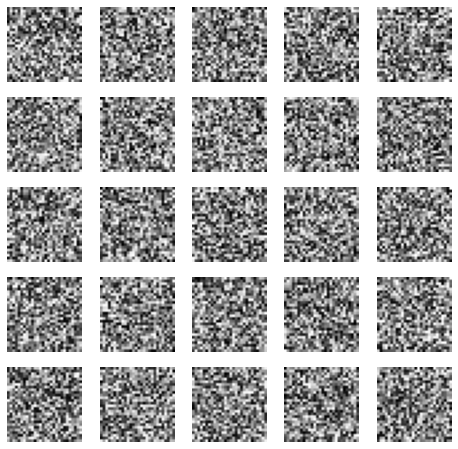

In [7]:
# random fake image generated by uniform distribution.
plt.figure(figsize=(8, 8))
for i in range(n_samples):
    img = transforms.ToPILImage()(torch.randn_like(train_dataset[0][0]))
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')
plt.show()

## 辨别器模型

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_shapes=(1, 1, 28, 28)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shapes[1], 64, 3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.4),
            nn.Flatten(),
            nn.Linear(64*(in_shapes[2] // 4)*(in_shapes[3] // 4), 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.model(x)
    
in_shapes = (1, 1, 28, 28)
modelD = Discriminator(in_shapes)

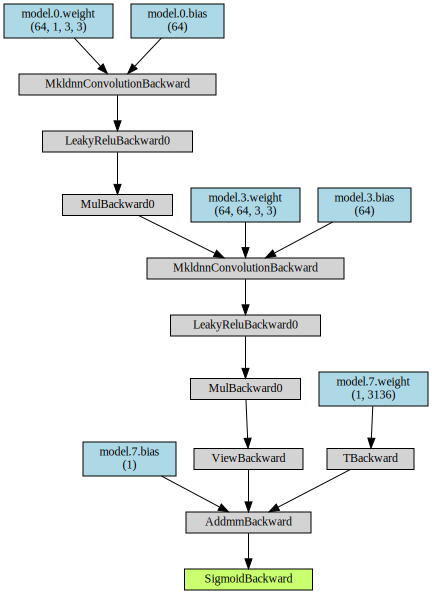

In [9]:
inputs = torch.zeros(*in_shapes, dtype=torch.float, requires_grad=False)
make_dot(modelD(inputs), params=dict(modelD.named_parameters()))

In [10]:
summary(modelD, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                    [-1, 1]           3,137
           Sigmoid-9                    [-1, 1]               0
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
---------------------------------------------

In [11]:
## 测试

num_epochs = 1
print_freq = 10
lr = 0.0002

dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4, drop_last=True)

d_optimizer = optim.Adam(modelD.parameters(), lr)

d_criterion = nn.BCELoss()

modelD.cuda()
modelD.train()

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(dataloader):
        real_image = image.to('cuda')
        real_label = torch.ones_like(label.unsqueeze(dim=1), dtype=torch.float, device='cuda')
        fake_image = torch.randn_like(real_image)
        fake_label = torch.zeros_like(real_label)
        x = torch.cat([real_image, fake_image], dim=0)
        y = torch.cat([real_label, fake_label], dim=0)
        d_optimizer.zero_grad()
        y_hat = modelD(x)
        d_loss = d_criterion(y_hat, y)
        d_loss.backward()
        d_optimizer.step()
        
        if i % print_freq == 0:
            acc = (y_hat.detach() > 0.5).eq(y).sum().cpu().numpy() / (2 * image.shape[0])
            print("iter:", i, "acc:", acc, "loss:", d_loss.item())
            if acc >= 1.0:
                break

iter: 0 acc: 0.3671875 loss: 0.7104383707046509
iter: 10 acc: 0.953125 loss: 0.4649809002876282
iter: 20 acc: 1.0 loss: 0.23829244077205658


## 生成器模型

In [12]:
class nn_Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(),
            nn_Reshape(-1, 256, 7, 7),
            nn.Conv2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)
    
latent_dim = 100
modelG = Generator(latent_dim)

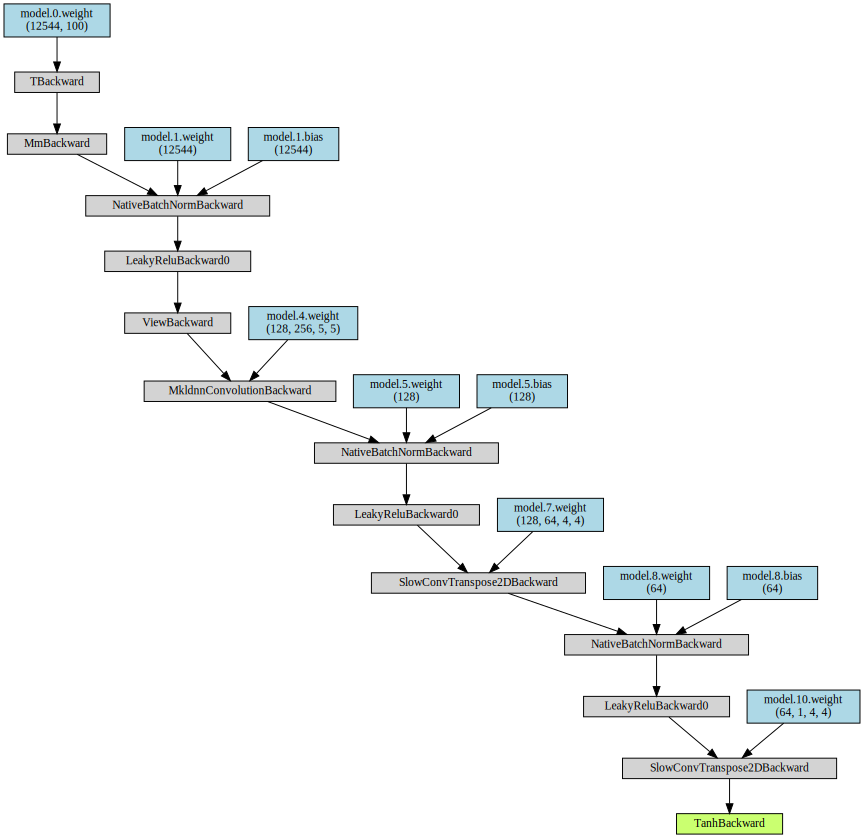

In [13]:
inputs = torch.randn(2, latent_dim, dtype=torch.float, requires_grad=False)
make_dot(modelG(inputs), params=dict(modelG.named_parameters()))

In [14]:
summary(modelG, input_size=(100,), batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,254,400
       BatchNorm1d-2                [-1, 12544]          25,088
         LeakyReLU-3                [-1, 12544]               0
        nn_Reshape-4            [-1, 256, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]         819,200
       BatchNorm2d-6            [-1, 128, 7, 7]             256
         LeakyReLU-7            [-1, 128, 7, 7]               0
   ConvTranspose2d-8           [-1, 64, 14, 14]         131,072
       BatchNorm2d-9           [-1, 64, 14, 14]             128
        LeakyReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]           1,024
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 2,231,168
Trainable params: 2,231,168
Non-trainable params: 0
---------------------------

## 训练

In [15]:
def set_requires_grad(net, requires_grad=False):
    for param in net.parameters():
        param.requires_grad = requires_grad

### 方式一

In [16]:
D = Discriminator(in_shapes)
G = Generator(latent_dim=100)

In [17]:
num_epochs = 120
print_freq = 50

d_lr = 0.001
g_lr = 0.002

dataloader = DataLoader(train_dataset, batch_size=256, num_workers=4)

d_optimizer = optim.Adam(D.parameters(), d_lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), g_lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

D.cuda().train()
G.cuda().train()

metrics = []
iter_count = 1
for epoch in range(num_epochs):
    for image, label in dataloader:
        real_image = image.to('cuda')
        real_label = torch.ones_like(label.unsqueeze(dim=1), dtype=torch.float, device='cuda')
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        ########### train discriminator model ###########
        set_requires_grad(D, True)
        latent = torch.randn(image.shape[0], latent_dim, dtype=torch.float)
        with torch.no_grad():
            fake_image = G(latent.to('cuda'))
            fake_label = torch.zeros_like(real_label)
            x = torch.cat([real_image, fake_image], dim=0)
            y = torch.cat([real_label, fake_label], dim=0)
        y_hat = D(x)
        d_loss = criterion(y_hat, y)
        d_loss.backward()
        d_optimizer.step()
        
        ########### train generator model (frozen D network) ###########
        set_requires_grad(D, False)
        latent = torch.randn(image.shape[0], latent_dim, dtype=torch.float)
        fake_image = G(latent.to('cuda'))
        fake_label = D(fake_image)
        g_loss = criterion(fake_label, torch.ones_like(fake_label))
        g_loss.backward()
        g_optimizer.step()
        
        if iter_count % print_freq == 0:
            acc = (y_hat.detach() > 0.5).eq(y).sum().cpu().numpy() / (2 * image.shape[0])
            dls = d_loss.item()
            gls = g_loss.item()
            metrics.append((iter_count, acc, dls, gls))
            print(metrics[-1], end='\r', flush=True)
            
        iter_count += 1
        
torch.save(D.state_dict(), '/data/D.pth')
torch.save(G.state_dict(), '/data/G.pth')

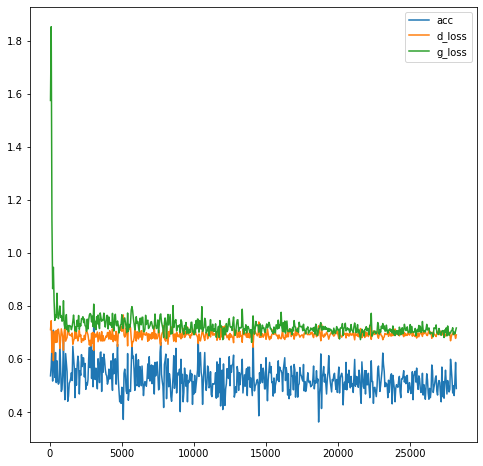

In [18]:
nm = np.array(metrics)
plt.figure(figsize=(8,8))
lines = plt.plot(nm[:, 0].astype(np.int), nm[:, 1:])
plt.legend(iter(lines), ('acc', 'd_loss', 'g_loss'));

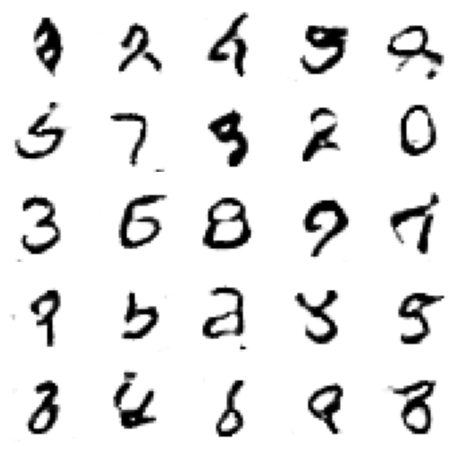

In [19]:
plt.figure(figsize=(8, 8))
G.eval()
with torch.no_grad():
    for i in range(n_samples):
        latent = torch.randn(1, latent_dim, dtype=torch.float)
        fake_image = G(latent.to('cuda'))
        fake_image = fake_image * 0.5 + 0.5
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(transforms.ToPILImage()(fake_image[0].cpu()), cmap='gray_r')

### 方式二

In [20]:
D2 = Discriminator(in_shapes)
G2 = Generator(latent_dim=100)

In [21]:
num_epochs = 120
print_freq = 50

d_lr = 0.0001
g_lr = 0.0002

dataloader = DataLoader(train_dataset, batch_size=256, num_workers=4)

d_optimizer = optim.Adam(D2.parameters(), d_lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G2.parameters(), g_lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

D2.cuda().train()
G2.cuda().train()

metrics = []
iter_count = 1
for epoch in range(num_epochs):
    for _, (image, label) in enumerate(dataloader):
        real_image = image.to('cuda')
        real_label = torch.ones_like(label.unsqueeze(dim=1), dtype=torch.float, device='cuda')
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        ########### train discriminator model ###########
        set_requires_grad(D2, True)
        ### real
        d_real_y = D2(real_image)
        d_real_loss = criterion(d_real_y, real_label)
        
        ### fake
        latent = torch.randn(image.shape[0], latent_dim, dtype=torch.float)
        with torch.no_grad():
            fake_image = G2(latent.to('cuda'))
        d_fake_y = D2(fake_image)
        d_fake_loss = criterion(d_fake_y, torch.zeros_like(real_label))
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()
        
        ########### train generator model ###########
        set_requires_grad(D2, False)
        latent = torch.randn(image.shape[0], latent_dim, dtype=torch.float)
        fake_image = G2(latent.to('cuda'))
        fake_label = D2(fake_image)
        g_loss = criterion(fake_label, torch.ones_like(fake_label))
        g_loss.backward()
        g_optimizer.step()
        
        if iter_count % print_freq == 0:
            real_acc = (d_real_y.detach() > 0.5).sum().cpu().numpy() / image.shape[0]
            fake_acc = (d_fake_y.detach() < 0.5).sum().cpu().numpy() / image.shape[0]
            real_loss = d_real_loss.item() # / image.shape[0]
            fake_loss = d_fake_loss.item() # / image.shape[0]
            dls = d_loss.item() # / image.shape[0]
            gls = g_loss.item() # / image.shape[0]
            metrics.append((iter_count, real_acc, fake_acc, real_loss, fake_loss, dls, gls))
            print(metrics[-1], end='\r', flush=True)
        iter_count += 1
torch.save(D2.state_dict(), '/data/D2.pth')
torch.save(G2.state_dict(), '/data/G2.pth')

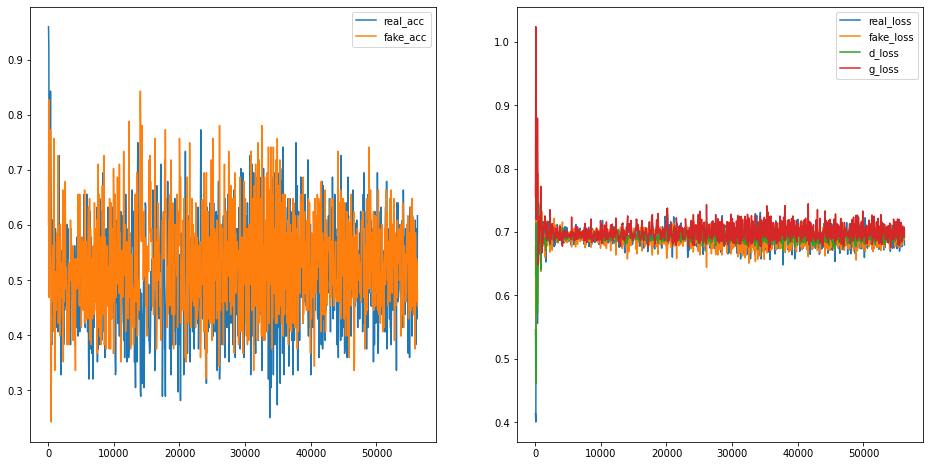

In [22]:
nm = np.array(metrics)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
lines = plt.plot(nm[:, 0].astype(np.int), nm[:, 1:3])
plt.legend(iter(lines), ('real_acc', 'fake_acc'));
plt.subplot(1, 2, 2)
lines = plt.plot(nm[:, 0].astype(np.int), nm[:, 3:])
plt.legend(iter(lines), ('real_loss', 'fake_loss', 'd_loss', 'g_loss'));

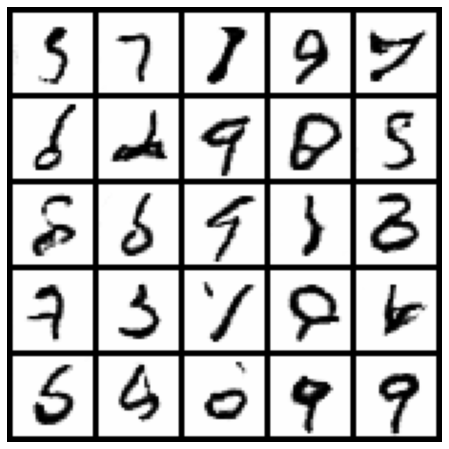

In [23]:
G2.eval()
with torch.no_grad():
    latent = torch.randn(n_samples, latent_dim, dtype=torch.float)
    fake_images = G2(latent.to('cuda')).cpu() * -1 # cmap: gray_r
    image = torchvision.utils.make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image.numpy().transpose((1, 2, 0)))

## References

- https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60

- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

- https://github.com/ConorLazarou/pytorch-generative-models/blob/master/GAN/DCGAN/dcgan_mnist.py